In [3]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pickle
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/dsrscientist/Data-Science-ML-Capstone-Projects/master/baseball.csv')
df.describe()

,W,R,AB,H,2B,3B,HR,BB,SO,SB,RA,ER,ERA,CG,SHO,SV,E
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.00000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,80.966667,688.233333,5516.266667,1403.533333,274.733333,31.300000,163.633333,469.100000,1248.20000,83.500000,688.233333,635.833333,3.956333,3.466667,11.300000,43.066667,94.333333
std,10.453455,58.761754,70.467372,57.140923,18.095405,10.452355,31.823309,57.053725,103.75947,22.815225,72.108005,70.140786,0.454089,2.763473,4.120177,7.869335,13.958889
min,63.000000,573.000000,5385.000000,1324.000000,236.000000,13.000000,100.000000,375.000000,973.00000,44.000000,525.000000,478.000000,2.940000,0.000000,4.000000,28.000000,75.000000
25%,74.000000,651.250000,5464.000000,1363.000000,262.250000,23.000000,140.250000,428.250000,1157.50000,69.000000,636.250000,587.250000,3.682500,1.000000,9.000000,37.250000,86.000000
50%,81.000000,689.000000,5510.000000,1382.500000,275.500000,31.000000,158.500000,473.000000,1261.50000,83.500000,695.500000,644.500000,4.025000,3.000000,12.000000,42.000000,91.000000
75%,87.750000,718.250000,5570.000000,1451.500000,288.750000,39.000000,177.000000,501.250000,1311.50000,96.500000,732.500000,679.250000,4.220000,5.750000,13.000000,46.750000,96.750000
max,100.000000,891.000000,5649.000000,1515.000000,308.000000,49.000000,232.000000,570.000000,1518.00000,134.000000,844.000000,799.000000,5.040000,11.000000,21.000000,62.000000,126.000000


There are no missing values in any column (min not 0).
The standard deviation is small compared to the mean, which indicates a lack of outliers.
There is a high difference between 75% and max values of H, 2B, HR, SO, SB, RA, ERA, CG, SHO, SV - Need to check for outliers.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   W       30 non-null     int64  
 1   R       30 non-null     int64  
 2   AB      30 non-null     int64  
 3   H       30 non-null     int64  
 4   2B      30 non-null     int64  
 5   3B      30 non-null     int64  
 6   HR      30 non-null     int64  
 7   BB      30 non-null     int64  
 8   SO      30 non-null     int64  
 9   SB      30 non-null     int64  
 10  RA      30 non-null     int64  
 11  ER      30 non-null     int64  
 12  ERA     30 non-null     float64
 13  CG      30 non-null     int64  
 14  SHO     30 non-null     int64  
 15  SV      30 non-null     int64  
 16  E       30 non-null     int64  
dtypes: float64(1), int64(16)
memory usage: 4.1 KB


All Data is discrete (int), except ERA.

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns

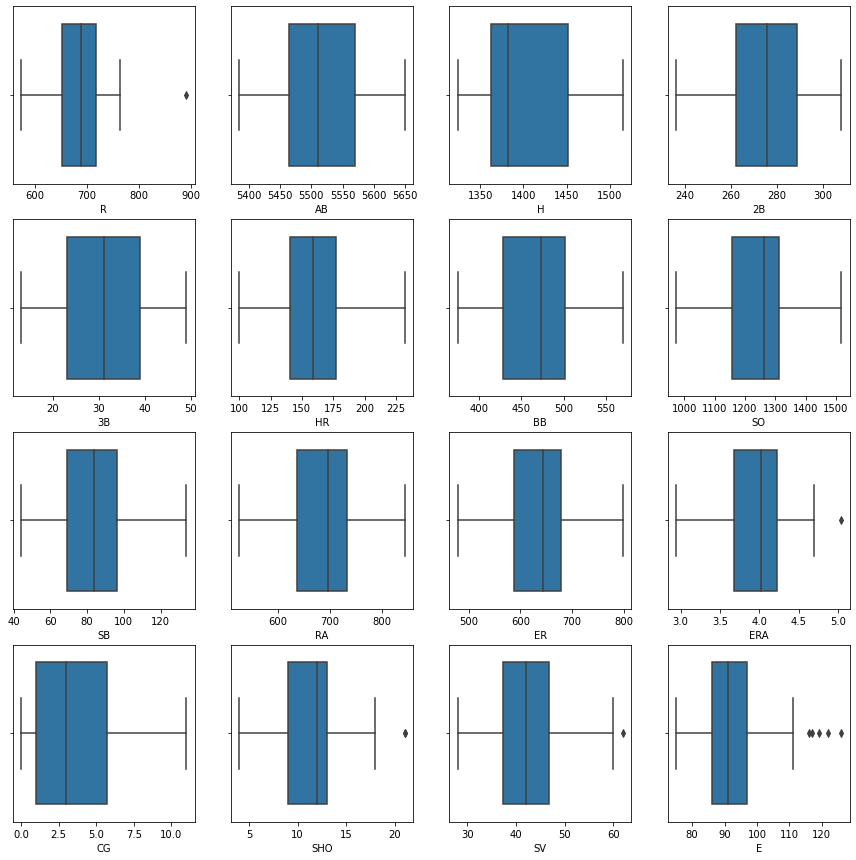

In [7]:
plt.figure(figsize=(15,15))
gr = 1
for c in df.drop('W', axis = 1):
    ax = plt.subplot(4, 4, gr)
    sns.boxplot(df.drop('W', axis = 1)[c], orient = 'V')
    plt.xlabel(c, fontsize = 10)
    gr+=1
plt.show()

R, SHO, SV and E, ERA are right skewed and show outliers.
We'll find the number of outliers using interquartile range

In [8]:
q1  = df.drop('W', axis = 1).quantile(0.25)
q3  = df.drop('W', axis = 1).quantile(0.75)
iqr = q3 - q1
o_R = (q3.R + (1.5*iqr.R))
o_SHO = (q3.SHO + (1.5*iqr.SHO))
o_SV = (q3.SV + (1.5*iqr.SV))
o_E = (q3.E + (1.5*iqr.E))
o_ERA = (q3.ERA + (1.5*iqr.ERA))
print(o_E, o_R, o_SHO, o_SV, o_ERA)

112.875 818.75 19.0 61.0 5.026250000000001


In [9]:
ind1 = np.where(df['E']> o_E)
ind2 = np.where(df['R']> o_R)
ind3 = np.where(df['SHO']> o_SHO)
ind4 = np.where(df['SV']> o_SV)
ind5 = np.where(df['ERA']> o_ERA)
print (ind1, ind2, ind3, ind4, ind5)

(array([10, 14, 16, 18, 24], dtype=int64),) (array([5], dtype=int64),) (array([17, 25], dtype=int64),) (array([15], dtype=int64),) (array([29], dtype=int64),)


There are outliers in all but removing them will remove almost 33% data which is not recommended

In [10]:
df.skew()

W      0.047089
R      1.200786
AB     0.183437
H      0.670254
2B    -0.230650
3B     0.129502
HR     0.516441
BB     0.158498
SO    -0.156065
SB     0.479893
RA     0.045734
ER     0.058710
ERA    0.053331
CG     0.736845
SHO    0.565790
SV     0.657524
E      0.890132
dtype: float64

There is skew (>0.5) in R, H, CG, HR, SHO, HV and E 

In [11]:
from scipy.stats import zscore
z=np.abs(zscore(df.drop('W', axis=1)))
dfn=df[(z<3).all(axis=1)]
dfn.shape

(29, 17)

Lost 1 data point which is acceptable

In [12]:
dfn.describe()

,W,R,AB,H,2B,3B,HR,BB,SO,SB,RA,ER,ERA,CG,SHO,SV,E
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,80.551724,681.241379,5516.517241,1400.896552,273.586207,31.793103,161.275862,465.620690,1251.551724,83.344828,688.862069,636.758621,3.961724,3.344828,11.344828,43.379310,94.551724
std,10.384006,45.357040,71.701076,56.264265,17.269952,10.276114,29.600792,54.728821,103.930123,23.202949,73.300616,71.195734,0.461148,2.729153,4.185655,7.816712,14.153713
min,63.000000,573.000000,5385.000000,1324.000000,236.000000,13.000000,100.000000,375.000000,973.000000,44.000000,525.000000,478.000000,2.940000,0.000000,4.000000,28.000000,75.000000
25%,74.000000,650.000000,5463.000000,1363.000000,262.000000,26.000000,140.000000,426.000000,1159.000000,69.000000,635.000000,584.000000,3.670000,1.000000,9.000000,38.000000,86.000000
50%,81.000000,689.000000,5511.000000,1382.000000,274.000000,32.000000,156.000000,471.000000,1264.000000,83.000000,698.000000,646.000000,4.030000,3.000000,12.000000,43.000000,92.000000
75%,87.000000,713.000000,5571.000000,1420.000000,288.000000,39.000000,177.000000,496.000000,1312.000000,97.000000,733.000000,680.000000,4.240000,5.000000,13.000000,47.000000,97.000000
max,100.000000,764.000000,5649.000000,1515.000000,303.000000,49.000000,230.000000,567.000000,1518.000000,134.000000,844.000000,799.000000,5.040000,11.000000,21.000000,62.000000,126.000000


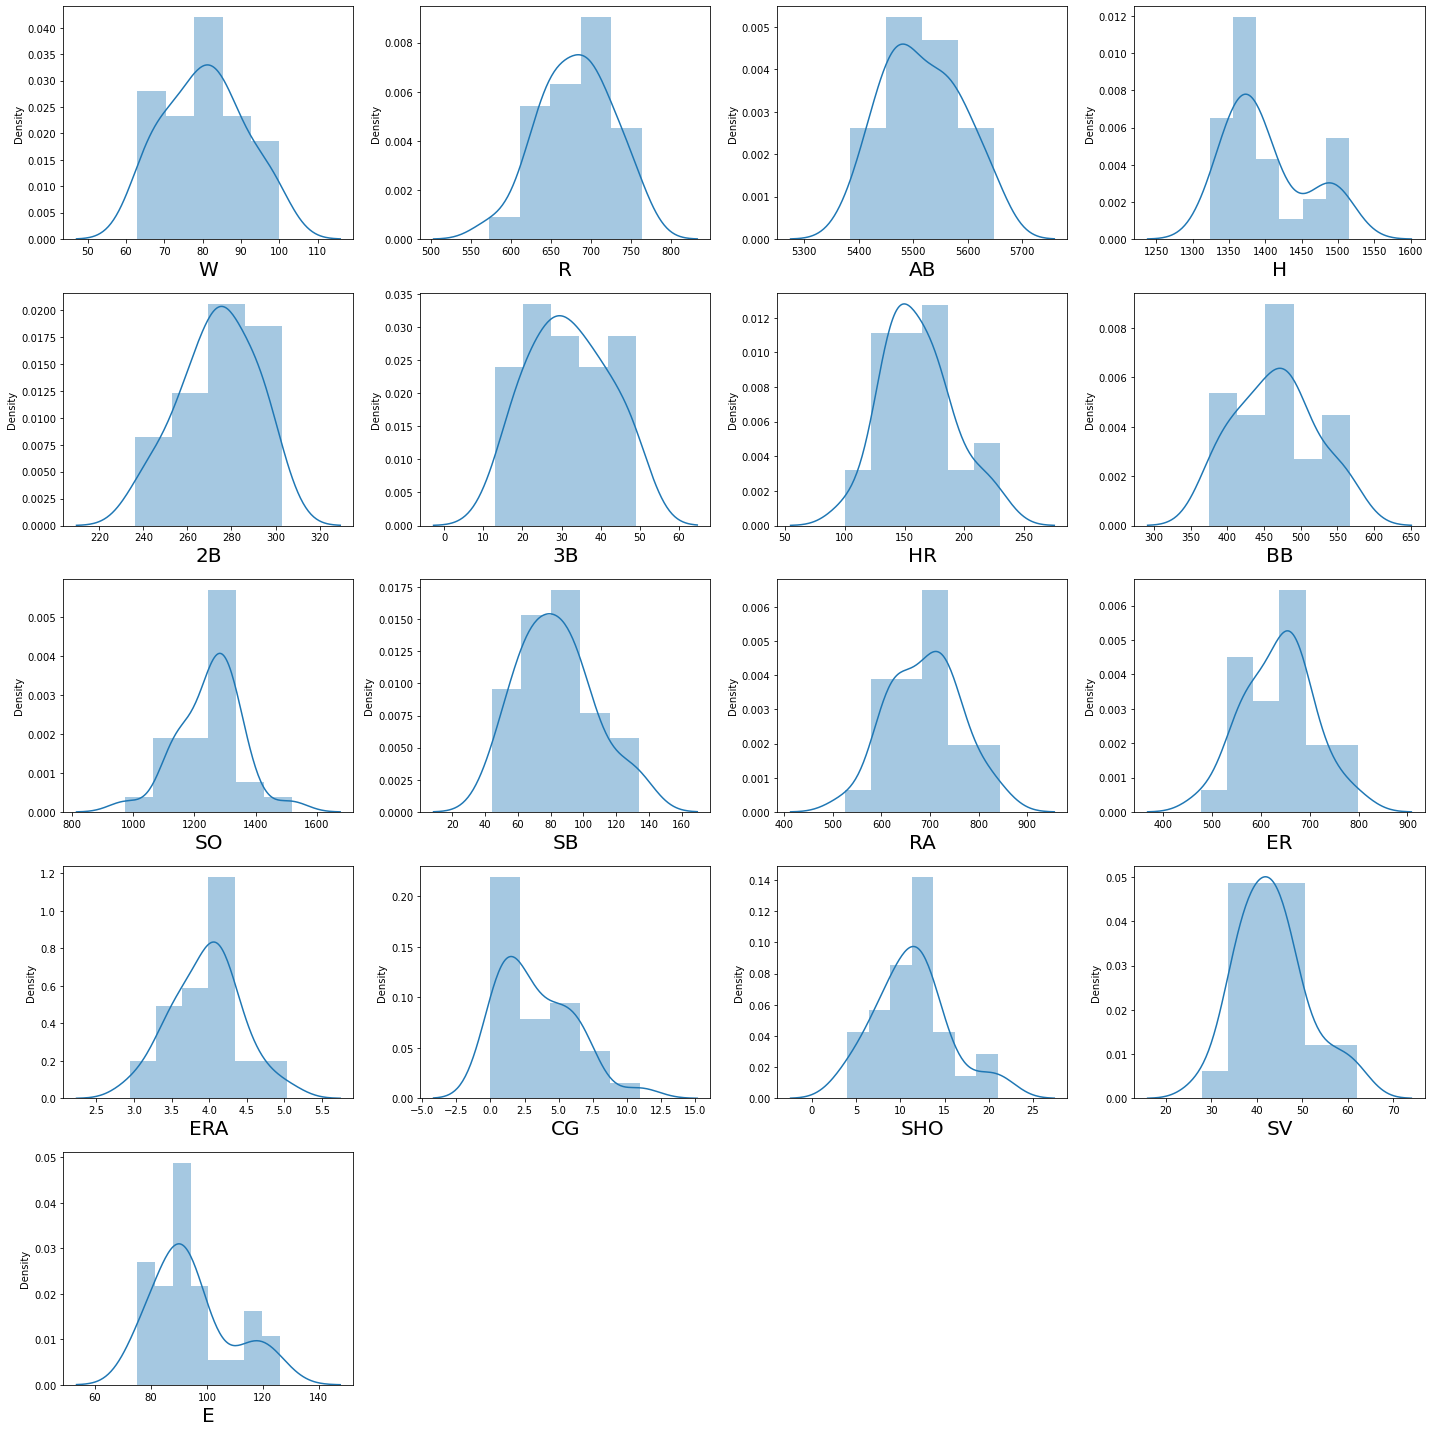

In [13]:
plt.figure(figsize=(20,20))
pltn = 1
for c in dfn:
    ax= plt.subplot(5,4,pltn)
    sns.distplot(dfn[c])  
    plt.xlabel(c,fontsize=20)
    pltn+=1
plt.tight_layout()

The data approaches normal. However, there is skew

In [14]:
dfn.skew()

W      0.119013
R     -0.215364
AB     0.169573
H      0.783772
2B    -0.335304
3B     0.090124
HR     0.450862
BB     0.151193
SO    -0.233815
SB     0.494966
RA     0.018155
ER     0.018461
ERA    0.016693
CG     0.854980
SHO    0.526943
SV     0.627480
E      0.840271
dtype: float64

There still is some skew in the data for which yeo-johnson will be used 

In [15]:
X = dfn.drop('W', axis = 1)
y = dfn['W']

In [16]:
X

,R,AB,H,2B,3B,HR,BB,SO,SB,RA,ER,ERA,CG,SHO,SV,E
0,724,5575,1497,300,42,139,383,973,104,641,601,3.73,2,8,56,88
1,696,5467,1349,277,44,156,439,1264,70,700,653,4.07,2,12,45,86
2,669,5439,1395,303,29,141,533,1157,86,640,584,3.67,11,10,38,79
3,622,5533,1381,260,27,136,404,1231,68,701,643,3.98,7,9,37,101
4,689,5605,1515,289,49,151,455,1259,83,803,746,4.64,7,12,35,86
6,764,5567,1397,272,19,212,554,1227,63,698,652,4.03,3,4,48,93
7,713,5485,1370,246,20,217,418,1331,44,693,646,4.05,0,10,43,77
8,644,5485,1383,278,32,167,436,1310,87,642,604,3.74,1,12,60,95
9,748,5640,1495,294,33,161,478,1148,71,753,694,4.31,3,10,40,97
10,751,5511,1419,279,32,172,503,1233,101,733,680,4.24,5,9,45,119


Skewness of data is taken care of, and so is standardization. Also, AB and H are 0, making them uncorrelated to the output 

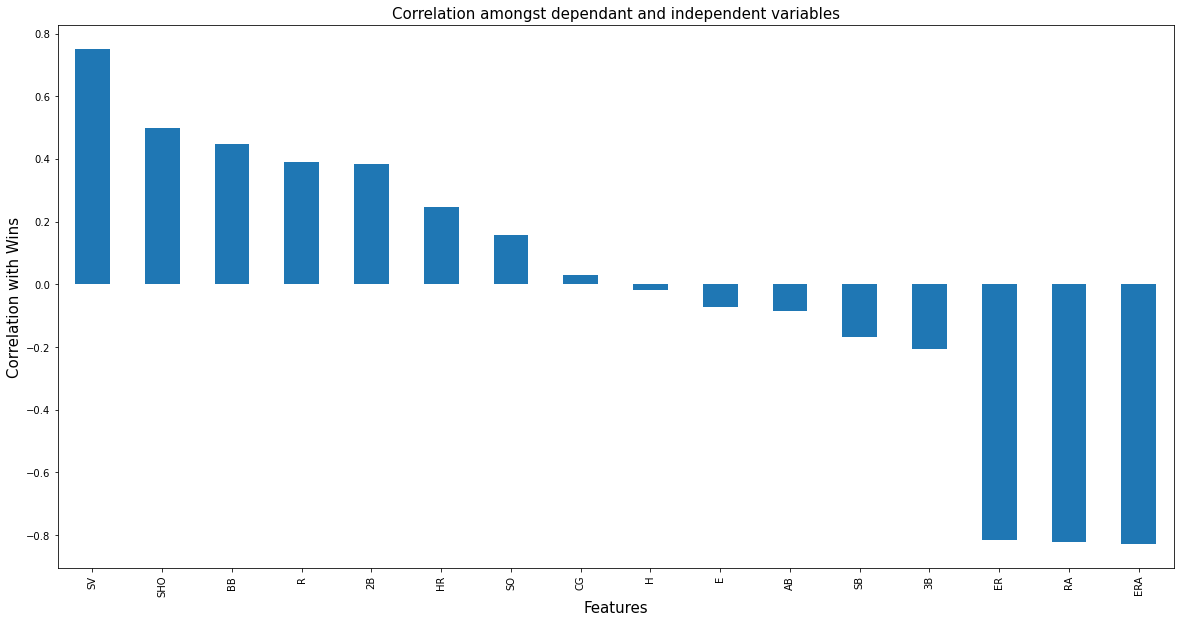

In [17]:
df2 = dfn.corr()
plt.figure(figsize=(20,10))
df2['W'].sort_values(ascending=False).drop('W').plot(kind='bar')
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Correlation with Wins', fontsize = 15)
plt.title('Correlation amongst dependant and independent variables', fontsize = 15)
plt.show()

SO, CG, H, E, SB, HR and AB have low correlation with W. Shall remove them if overfitting is an issue

In [18]:
from sklearn.preprocessing import PowerTransformer
power = PowerTransformer(method='yeo-johnson', standardize=True)
X = power.fit_transform(X)
X = pd.DataFrame(X)
X.columns = dfn.drop('W', axis=1).columns
X

,R,AB,H,2B,3B,HR,BB,SO,SB,RA,ER,ERA,CG,SHO,SV,E
0,0.962544,0.0,0.0,1.685188,1.006150,-0.741927,-1.605198,-2.550612,0.936132,-0.660979,-0.508052,-0.509292,-0.307098,-0.787002,1.532753,-0.348265
1,0.298863,0.0,0.0,0.138198,1.185227,-0.109958,-0.462096,0.093683,-0.516377,0.160226,0.235800,0.241440,-0.307098,0.236737,0.312020,-0.540820
2,-0.312105,0.0,0.0,1.907385,-0.228819,-0.664354,1.232098,-0.935611,0.225038,-0.674967,-0.752214,-0.642098,2.011315,-0.252844,-0.664137,-1.326125
3,-1.308298,0.0,0.0,-0.837665,-0.432228,-0.860039,-1.162721,-0.230683,-0.618422,0.174077,0.093091,0.043013,1.264463,-0.513555,-0.820689,0.650818
4,0.137737,0.0,0.0,0.911435,1.622636,-0.289647,-0.155686,0.044143,0.095038,1.575971,1.555853,1.493491,1.264463,0.236737,-1.149165,-0.540820
5,1.964209,0.0,0.0,-0.163010,-1.295827,1.631637,1.579494,-0.269583,-0.884526,0.132517,0.221537,0.153276,0.121871,-2.064039,0.677176,0.082858
6,0.698146,0.0,0.0,-1.542635,-1.182758,1.767734,-0.877217,0.770980,-2.082843,0.063208,0.135920,0.197363,-1.732896,-0.252844,0.052325,-1.588197
7,-0.852595,0.0,0.0,0.199897,0.068703,0.269125,-0.520476,0.556008,0.267558,-0.646992,-0.465016,-0.487168,-0.870682,0.236737,1.908137,0.237592
8,1.555951,0.0,0.0,1.255256,0.166017,0.065014,0.270944,-1.019210,-0.466233,0.891396,0.819308,0.769577,0.121871,-0.252844,-0.365006,0.383386
9,1.631727,0.0,0.0,0.262086,0.068703,0.434620,0.717576,-0.211199,0.824915,0.616173,0.620346,0.615685,0.770649,-0.513555,0.312020,1.554265


Since AB and H have very low variance, they do not contribute anything to the output. They also have been converted to 0 by yeo-johnson. Hence, we remove the data from factors 

In [19]:
X = X.drop(['AB', 'H'], axis = 1)

In [20]:
vif = pd.DataFrame()
Xsc = np.asarray(X)
vif['score'] = [variance_inflation_factor(Xsc,i) for i in range (Xsc.shape[1])]
vif['Feature'] = X.columns
vif

,score,Feature
0,3.806498,R
1,2.783464,2B
2,2.950443,3B
3,5.968093,HR
4,3.197536,BB
5,2.965124,SO
6,2.058844,SB
7,188.313378,RA
8,599.940988,ER
9,337.133612,ERA


We need to remove data with high vif to avoid multicollinearity. In this case, ERA than ER is a better tool to evaluate performance. 

In [21]:
X = X.drop(['ER'], axis = 1)
vif1 = pd.DataFrame()
Xsc = np.asarray(X)
vif1['score'] = [variance_inflation_factor(Xsc,i) for i in range (Xsc.shape[1])]
vif1['Feature'] = X.columns
vif1

,score,Feature
0,3.733918,R
1,2.763491,2B
2,2.917934,3B
3,4.528519,HR
4,3.132878,BB
5,2.517925,SO
6,1.672145,SB
7,92.783638,RA
8,94.855795,ERA
9,2.176316,CG


THough ERA and RA are correlated, it is important to keep them both as 1 reduces variances and other reduces bias. That is the nature of the data

In [22]:
from sklearn.feature_selection import SelectKBest, f_classif
bf= SelectKBest(score_func = f_classif, k='all')
fit = bf.fit(X,y)
df_scores=pd.DataFrame(fit.scores_)
df_columns=pd.DataFrame(X.columns)

#concatenate dataframes
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature name', 'Score']
print(feature_scores.nlargest(13,'Score'))

   Feature name     Score
12            E  4.329879
7            RA  2.581666
0             R  2.402450
6            SB  2.159375
11           SV  1.764635
8           ERA  1.752234
5            SO  1.524178
10          SHO  1.003077
4            BB  0.930185
3            HR  0.914352
2            3B  0.789711
1            2B  0.747017
9            CG  0.436693


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 4)

In [24]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
knn = KNeighborsRegressor()
lreg = LinearRegression()
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()

In [25]:
lreg.fit(X_train, y_train)
dt.fit(X_train, y_train)
knn.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor()

All data has been trained in different models

In [26]:
print(lreg.score(X_test, y_test), dt.score(X_test, y_test), knn.score(X_test, y_test), rf.score(X_test, y_test))

0.8053551808778172 -0.889795238887964 0.6341867820875646 0.78390491093724


All models show high accuracy. Though, we may try to increase the accuracy through removal of low correlation data.

In [27]:
X1 = X.drop(['CG', '2B', '3B', 'HR', 'BB', 'SHO'], axis = 1)

Removing the low correlation factors CG, 2B, 3B, HR, BB and SHO which also have low scores of K

In [28]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y, test_size = 0.25, random_state = 4)

In [29]:
lreg.fit(X1_train, y1_train)
dt.fit(X1_train, y1_train)
knn.fit(X1_train, y1_train)
rf.fit(X1_train, y1_train)

RandomForestRegressor()

In [30]:
print(lreg.score(X1_test, y1_test), dt.score(X1_test, y1_test), knn.score(X1_test, y1_test), rf.score(X1_test, y1_test))

0.8621212316485717 0.7136673880472781 0.6332811719660395 0.817281971033794


Linear regression is the most accurate. Performing HPT via L1 and L2 CV methods

In [31]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV 

In [32]:
lcv = LassoCV(alphas = None, max_iter = 1000, normalize = False)
lcv.fit(X1_train, y1_train)
alpha = lcv.alpha_
lasso_reg = Lasso(alpha)
lasso_reg.fit(X1_train, y1_train)
lasso_reg.score(X1_test, y1_test)

0.8778564283557696

The accuracy was improved a little. Trying with Ridge CV

In [33]:
rcv = RidgeCV(alphas = np.arange(0.0001, 1, 0.0001), normalize = False)
rcv.fit(X1_train, y1_train)
al = rcv.alpha_
ridge_reg = Ridge(al)
ridge_reg.fit(X1_train, y1_train)
ridge_reg.score(X1_test, y1_test)

0.8779618223042611

The highest accuracy is achieved through RidgeCV at almost 88%. So, saving that model. Also, proves that there is no overfitting

In [34]:
filename = 'Baseball.pickle'
pickle.dump(ridge_reg, open(filename, 'wb'))